In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datasets import load_from_disk
from PIL import Image
from typing import Dict, List, Tuple

from mrl_loader import MRLLoader
from linear_metrics import LinearMetricsCalculator, compute_linear_metrics

/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "/home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/train/logs/98819cd7-62aa-479e-8642-f4333540615e/final_weights.pt" 
model = MRLLoader(model_path)

Initializing resnet50 model...


/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying BlurPool...
Loading weights from /home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/train/logs/98819cd7-62aa-479e-8642-f4333540615e/final_weights.pt...
Model weights loaded successfully!


/home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/mrl_loader.py:592: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.weights_path, map_location='c

Model loaded on cuda
Available embedding dimensions: [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Output embedding dimension set to 8


In [3]:
model

In [4]:
random_input = torch.randn(4, 3, 224, 224)
predictions, embeddings = model.predict_with_embeddings(random_input)
predictions.shape, embeddings.shape

(torch.Size([4, 1000]), torch.Size([4, 8]))

In [5]:
model.set_output_emb_dim(16)

Output embedding dimension set to 16


In [6]:
predictions, embeddings = model.predict_with_embeddings(random_input)
predictions.shape, embeddings.shape

(torch.Size([4, 1000]), torch.Size([4, 16]))

In [7]:
dataset_path = "data/imagenet_1k_resized_256_test"
ds = load_from_disk(dataset_path)
print(f"Loaded dataset with {len(ds)} samples")

Loaded dataset with 100000 samples


In [8]:
sample = ds[0]
print(f"Sample image shape: {sample['image'].size}, Label: {sample['label']}")

Sample image shape: (373, 256), Label: -1


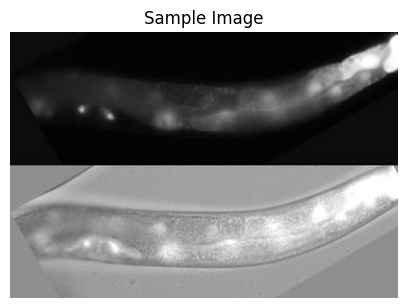

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['image'])
plt.axis('off')
plt.title("Sample Image")
plt.show()

In [10]:
def extract_embeddings(model: MRLLoader, 
                       dataset, 
                       embedding_dim: int, 
                       batch_size: int = 32, 
                       num_samples: int = None,
                       random_seed: int = 42) -> np.ndarray:
    """
    Extract embeddings from the model for images in the dataset.
    
    Args:
        model: MRLLoader model
        dataset: HuggingFace dataset
        embedding_dim: Embedding dimension to use
        batch_size: Batch size for processing
        num_samples: Number of samples to process (None = all)
        random_seed: Random seed for sampling
        
    Returns:
        Array of embeddings with shape (num_samples, embedding_dim)
    """
    # Set the embedding dimension
    model.set_output_emb_dim(embedding_dim)
    
    # Determine number of samples to process
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # If we're not using all samples, randomly select indices
    if num_samples < len(dataset):
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = range(num_samples)
    
    # Initialize array to store embeddings
    all_embeddings = []
    all_labels = []
    
    # Process in batches
    for i in tqdm(range(0, len(indices), batch_size), desc=f"Extracting {embedding_dim}d embeddings"):
        batch_indices = indices[i:i+batch_size]
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            
            batch_images.append(image)
            batch_labels.append(label)
        
        # Get embeddings for the batch
        with torch.no_grad():
            _, embeddings = model.predict_with_embeddings(batch_images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(batch_labels)
    
    # Concatenate all batches
    embeddings_array = np.vstack(all_embeddings)
    labels_array = np.array(all_labels)
    
    print(f"Extracted {embeddings_array.shape[0]} embeddings with dimension {embeddings_array.shape[1]}")
    return embeddings_array, labels_array

In [11]:
# embedding_dims = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
embedding_dims = [8, 16]

In [12]:
num_samples = len(ds)

In [13]:
embeddings_dict = {}
labels = None

for dim in embedding_dims:
    embeddings_array, labels_array = extract_embeddings(
        model=model,
        dataset=ds,
        embedding_dim=dim,
        batch_size=64,
        num_samples=num_samples
    )
    embeddings_dict[dim] = embeddings_array
    
    # Store labels once (they should be the same for all dimensions)
    if labels is None:
        labels = labels_array
    
    print(f"Embeddings for dimension {dim}: {embeddings_array.shape}")

Output embedding dimension set to 8


Extracting 8d embeddings: 100%|██████████| 1563/1563 [05:13<00:00,  4.98it/s]


Extracted 100000 embeddings with dimension 8
Embeddings for dimension 8: (100000, 8)
Output embedding dimension set to 16


Extracting 16d embeddings: 100%|██████████| 1563/1563 [05:11<00:00,  5.02it/s]

Extracted 100000 embeddings with dimension 16
Embeddings for dimension 16: (100000, 16)


In [14]:
metrics_calculator = LinearMetricsCalculator()

# Dictionary to store metrics for each dimension
metrics_results = {}

# Calculate metrics for each embedding dimension
for dim, embeddings in embeddings_dict.items():
    print(f"Computing metrics for {dim}d embeddings...")
    metrics = metrics_calculator.compute_metrics(embeddings, cache_key=f"dim_{dim}")
    metrics_results[dim] = metrics
    
    # Print key metrics
    print(f"  Effective Rank: {metrics['effective_rank']:.2f}")
    print(f"  Condition Number: {metrics['condition_number']:.2f}")
    print(f"  Explained Variance (top 10): {metrics['explained_variance_top10']:.4f}")
    print(f"  Average Correlation: {metrics['avg_correlation']:.4f}")
    print()

Computing metrics for 8d embeddings...
  Effective Rank: 6.55
  Condition Number: 4.52
  Explained Variance (top 10): 1.0000
  Average Correlation: 0.1495

Computing metrics for 16d embeddings...
  Effective Rank: 11.88
  Condition Number: 7.86
  Explained Variance (top 10): 0.9410
  Average Correlation: 0.0946



/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
